<a href="https://colab.research.google.com/github/pjcroxas/Financial-Data-Science/blob/main/Customer_Segmentation_of_Online_Retail_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
drive.mount("/content/drive")

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
dirs = "/content/drive/My Drive/Data Science Portfolio/2023/Applied/data"
online_df = pd.read_excel(dirs+"/Online Retail.xlsx")
online_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Exploratory Data Analysis**

In [ ]:
online_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
online_df[["Quantity", "UnitPrice"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,13.412279,248.624170,1.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [ ]:
# Dropping null values
online_df.dropna(axis=0, inplace=True)

In [ ]:
# Converting the negative quantities to positive value
online_df["Quantity"] = online_df["Quantity"].apply(lambda x: np.abs(x))

<Axes: >

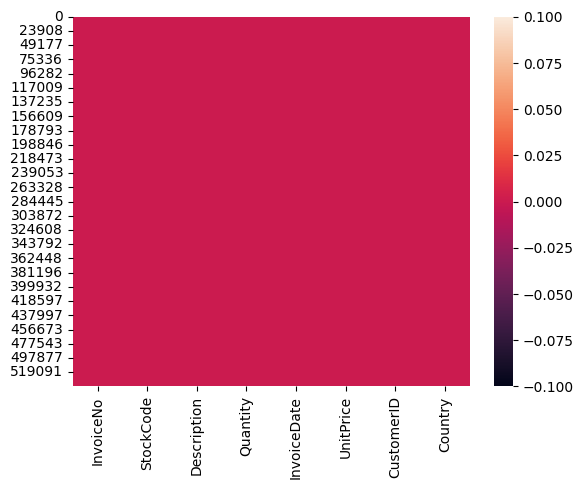

In [ ]:
sns.heatmap(online_df.isnull())

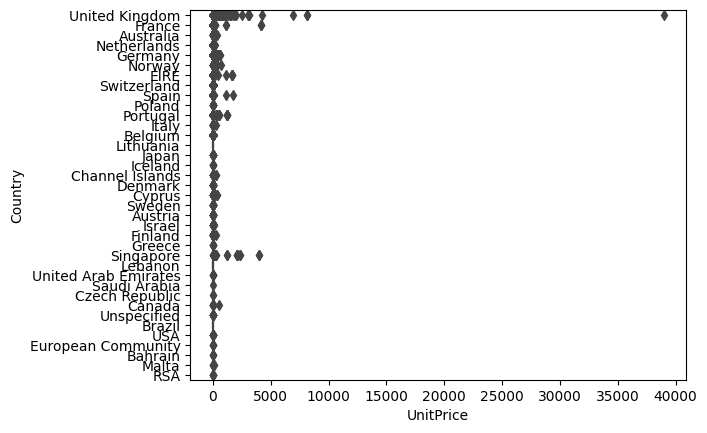

In [ ]:
# Visualize the distribution

sns.boxplot(data=online_df,
            x="UnitPrice",
            y="Country", orient="h")
plt.show()

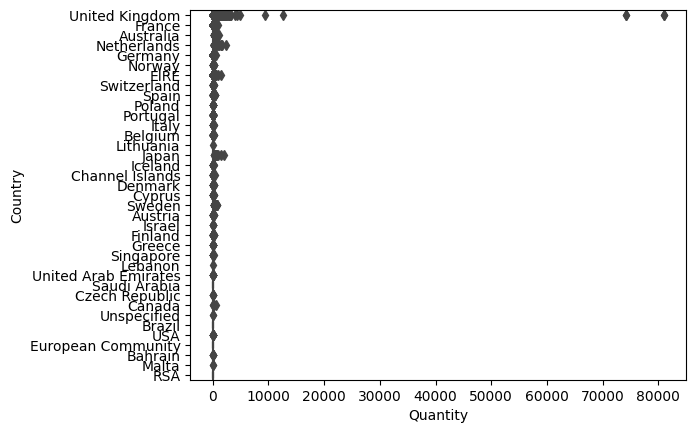

In [ ]:
sns.boxplot(data=online_df,
            x="Quantity",
            y="Country", orient="h")
plt.show()

# **Cohort Analysis**

**Cohort analysis** is a descriptive analytics tool that provides insights on metrics across both the product and the customer lifecycle. There are three (3) type of cohorts: *Time*, *Behavior*, and *Size*.

In this analysis, we will focus on `Time Cohort` - where we need to identify the customer that signed up during particular month. We can also shift to to daily or yearly. But most of the time, business monitors monthly time cohorts.

In [ ]:
# Create a dataframe copy in order to preserve the original.
online = online_df.copy()

**I. Assign Monthly Cohort**

Monthly Cohort is the earliest month where a customer bought a product or signup in the store/service.

In [ ]:
# Extract Datetime features
import datetime as dt

def get_month(x):
  return dt.datetime(x.year, x.month, 1)

# Create Invoice Month Column
online["InvoiceMonth"] = online["InvoiceDate"].apply(get_month)

# Create Cohort Month column
grouping_month = online.groupby("CustomerID")["InvoiceMonth"]

# Select the minimum date among Invoice Month
online["CohortMonth"] = grouping_month.transform("min")

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


**II. Calculate Cohort Index or Time Offset**
`CohortIndex` is a metric that represents the number of months since the first transaction. It can computed by:

                CohortIndex = InvoiceMonth - CohortMonth

First, we will calculate the difference of the year, and month component. To convert the result into monthly index:

- For Monthly: years_diff * 12 + months_diff + 1
- For Daily: years_diff * 365 + months_diff * 30 + days + 1

the +1 at the last part offsets the first day, or month of the cohort matrix

In [ ]:
def get_date_int(df, column):
    """Extracts the year, month,
     and day components.
    """
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [ ]:
# Get the integers for date parts from the 'InvoiceDay' column
invoice_year, invoice_month, _ = get_date_int(online, "InvoiceMonth")

# Get the integers for date parts from the 'CohortDay' column
cohort_year, cohort_month, _ = get_date_int(online, "CohortMonth")

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Monthly Cohort Index
online["CohortIndex"] = years_diff * 12 + months_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


**III. Calculate Retention Rate**

Retention rate is the metric that identify if a customer still buys or had membership to the succeeding months. We can identify it by grouping the the data by `CohortMonth` and `CohortIndex`.

In [ ]:
# Count the number of unique values per CustomerID
grouping = online.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique).reset_index()

# Create pivot
cohort_counts = cohort_data.pivot(index="CohortMonth",
                                  columns="CohortIndex",
                                  values="CustomerID")

# # Select the first column and store it to cohort sizes
cohort_sizes = cohort_counts.iloc[:, 0]

# # Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**III.B Visualizing Retention rate**

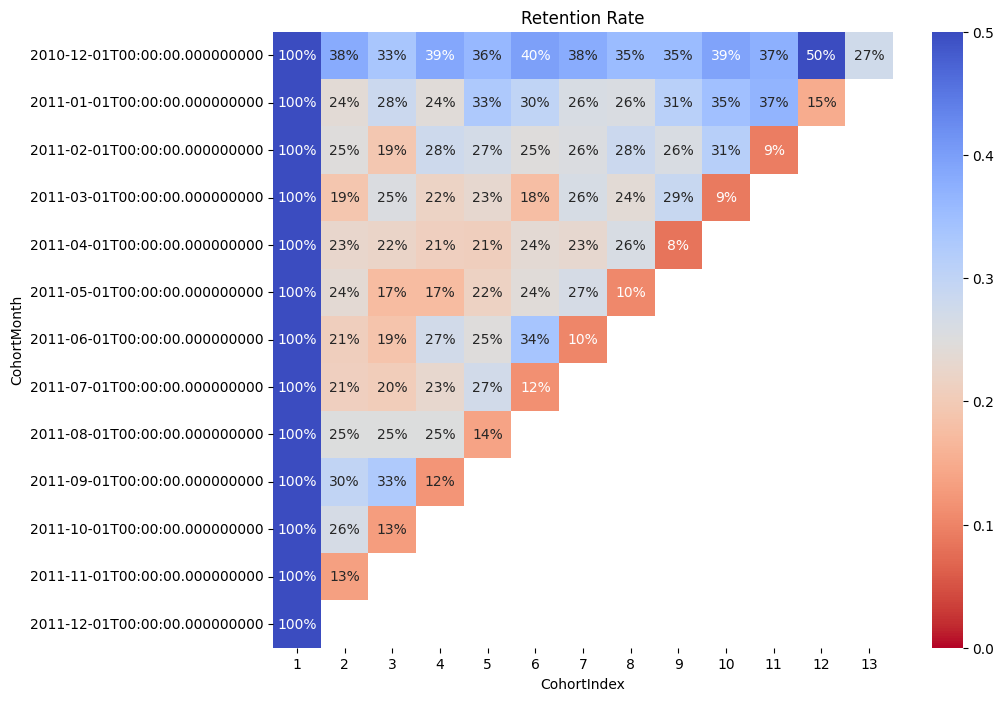

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Retention Rate")
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap="coolwarm_r")
plt.show()

- Retention rate for year 2011 is below average.
- Customers that signed up on December 2010 has a good standing for almost a year. However, the retentivity significantly decreases on December 2011. This indicates that there are customers that avails a discount or promo that expired at the end of the year.
- This also suggests that the business can slightly improve the retention rate by offering promos (3-month, 5-month, or yearly).

**IV. Calculate Average Price**

In [ ]:
# Calculate the average of the unit price column
grouping = online.groupby(["CohortMonth", "CohortIndex"])
avg_unit_price = grouping["UnitPrice"].mean().reset_index()

# Create Pivot
avg_price = avg_unit_price.pivot(index="CohortMonth",
                              columns="CohortIndex",
                              values="UnitPrice")
avg_price = avg_price.round(3)

**IV.B Visualizing Average Prices**

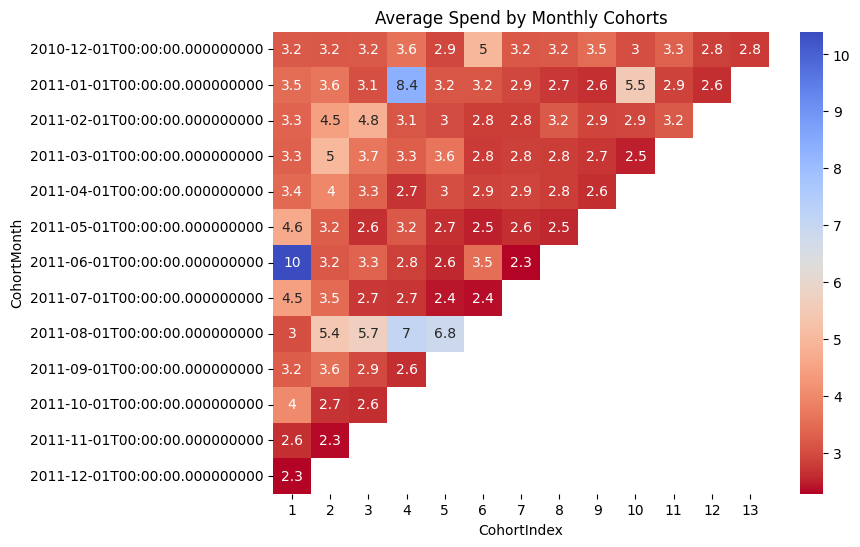

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Average Spend by Monthly Cohorts")
sns.heatmap(data=avg_price, annot=True, cmap="coolwarm_r")
plt.show()

# **Recency, Frequency, Monetary Value Analysis**

RFM analysis is a customer segmentation technique used by businesses to understand and categorize their customer base based on their past purchasing behavior. RFM stands for Recency, Frequency, and Monetary Value, which are three key metrics used to evaluate customer engagement and profitability. Here's a breakdown of each component of RFM analysis:

`Recency` (R): Recency refers to the time that has elapsed since a customer's last purchase or interaction with the business. It helps identify how recently a customer has engaged with the company. Customers who have made recent purchases are often considered more valuable, as they demonstrate active interest and engagement.

`Frequency` (F): Frequency represents the number of purchases or interactions a customer has had with the business over a specific period of time. It indicates how often a customer engages with the company. Customers with a higher frequency of purchases are generally considered more loyal and valuable.

`Monetary Value` (M): Monetary Value refers to the total amount of money a customer has spent on purchases with the business over a specific period. It measures the overall value or profitability of a customer. Customers with higher monetary value are typically more valuable to the business.

**V. Data Preparation**

First we will identify a `snapshot_date`, which is the most recent transaction date plus 1, in order to offset the latest transaction.

then we will group the date by customer and identify the (1) recency by subracting the snapshot date the latest transaction per customer. (2) We will count the invoice per customer for frequency, and (3) while for monetary, we will sum up the `TotalSum` per customer.

In [ ]:
# Create a snapshot date to obtain basis
print("Min: ", min(online.InvoiceDate), " - ", "Max: ", max(online.InvoiceDate))
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

# Create new column TotalSum
online["TotalSum"] = online["Quantity"] * online["UnitPrice"]

Min:  2010-12-01 08:26:00  -  Max:  2011-12-09 12:50:00


In [ ]:
# Calculate Recency, Frequency, and Monetary Value for each customer
rfm_data = online.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": 'count',
    "TotalSum": 'sum'
})

# Rename the columns
rfm_data.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
rfm_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,154367.20
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


**VI. Build RFM Segments**

In [ ]:
# Create Labels for Recency, Frequency, and Monetary Value
r_labels = range(3, 0, -1)
f_labels = range(1,4)
m_labels = range(1,4)

# Assign the labels to three equal percentile groups
r_groups = pd.qcut(rfm_data["Recency"], q=3, labels=r_labels)
f_groups = pd.qcut(rfm_data["Frequency"], q=3, labels=f_labels)
m_groups = pd.qcut(rfm_data["MonetaryValue"], q=3, labels=m_labels)

# Create new column from the previous dataframe created
rfm_data = rfm_data.assign(
    R=r_groups.values,
    F=f_groups.values,
    M=m_groups.values
)

rfm_data.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
16311.0,18,37,616.26,3,2,2
16776.0,60,76,388.28,2,3,1
12492.0,63,20,263.21,2,1,1
13228.0,81,2,358.00,2,1,1
16790.0,4,95,1571.12,3,3,3
16206.0,55,63,537.06,2,2,2
16558.0,1,474,8419.94,3,3,3
16589.0,71,33,459.24,2,2,2
16775.0,10,158,1695.66,3,3,3


VII. Calculate RFM Score and RFM Segment

In [ ]:
# NOTE: Run twice in order for RFM Segment have correct output e.g. 211
def join_rfm(x):
  return str(x["R"]) + str(x["F"]) + str(x["M"])

rfm_data["RFM_Segment"] = rfm_data.apply(join_rfm, axis=1)
rfm_data["RFM_Score"] = rfm_data[["R", "F", "M"]].sum(axis=1)
rfm_data.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
16793.0,57,16,243.84,2,1,1,211,4
15453.0,2,286,1388.37,3,3,3,333,9
13563.0,84,49,777.53,2,2,2,222,6
15247.0,122,6,356.00,1,1,1,111,3
17985.0,22,23,634.95,3,1,2,312,6
12566.0,73,20,356.60,2,1,1,211,4
15100.0,330,6,1116.90,1,1,2,112,4
12688.0,114,171,4873.81,1,3,3,133,7
17958.0,117,7,508.46,1,1,2,112,4


**VIII. Creating Custom Segments**

In [ ]:
# Create a helper function to create custom segment
def rfm_level(df):
    if df['RFM_Score'] == 9:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9)):
        return 'Middle'
    else:
        return 'Low'

In [ ]:
# Create new column RFM_Level
rfm_data["RFM_Level"] = rfm_data.apply(rfm_level, axis=1)
rfm_data.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
13109.0,3,50,806.24,3,2,2,322,7,Middle
13138.0,22,63,962.39,3,2,2,322,7,Middle
17080.0,22,9,289.74,3,1,1,311,5,Low
14730.0,1,501,2005.06,3,3,3,333,9,Top
15952.0,34,91,806.57,2,3,2,232,7,Middle
16362.0,32,90,817.47,2,3,2,232,7,Middle
15644.0,166,238,813.00,1,3,2,132,6,Middle
14970.0,68,34,1592.06,2,2,3,223,7,Middle
15998.0,37,509,3095.77,2,3,3,233,8,Middle


**IX. Analyzing Custom Segment**

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_level_agg = rfm_data.groupby("RFM_Level").agg({
    'Recency':'mean',
    'Frequency':'mean',

    # Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)
rfm_level_agg

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         160.9      20.1         524.1  1925
Middle       49.4      88.5        1835.3  1748
Top           9.1     305.4        7590.3   699

# **Data Preparation**

**I. Visualizing the distribution of RFM**

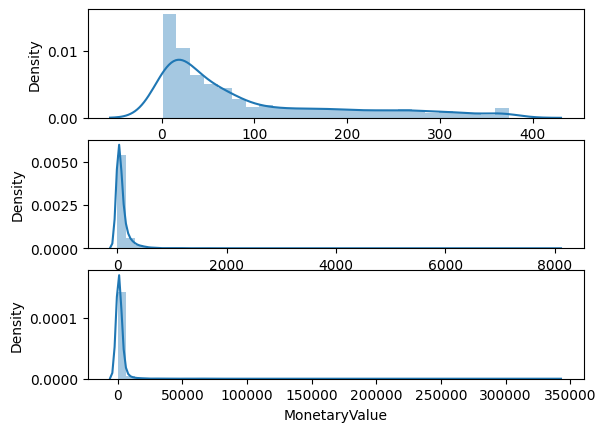

In [ ]:
columns = ["Recency", "Frequency", "MonetaryValue"]

for index, cols in enumerate(columns):
  plt.subplot(3,1,index+1)
  sns.distplot(rfm_data[cols])
plt.show()

**II. Managing the skewness using StandardScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, norm
from scipy import stats

In [ ]:
scaler = StandardScaler()
scaler2 = StandardScaler()
feature_data = np.log(rfm_data[["Recency", "Frequency", "MonetaryValue"]])
feature_data = feature_data[np.isfinite(feature_data).all(1)]
scaler.fit(feature_data)
rfm_data_normalized = scaler.transform(feature_data)
rfm_data_normalized = pd.DataFrame(data=rfm_data_normalized,
                                   index=feature_data.index,
                                   columns=["Recency", "Frequency", "MonetaryValue"])

rfm_data_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,1.402675,-2.232574,4.137318
12347.0,-2.075200,1.133640,1.372251
12348.0,0.399402,-0.187231,0.696371
12349.0,-0.538079,0.451908,0.679115
12350.0,1.368314,-0.635557,-0.603074


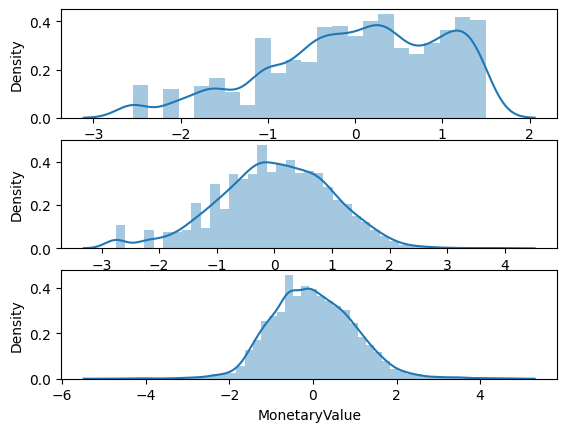

In [ ]:
columns = ["Recency", "Frequency", "MonetaryValue"]

for index, cols in enumerate(columns):
  plt.subplot(3,1,index+1)
  sns.distplot(rfm_data_normalized[cols])
  plt.xlabel(cols)
plt.show()

- `MonetaryValue` and `Recency` results to negative skewness after log transformation and standard scaling.

In [ ]:
#@title
# # Add positive integer
# rfm_data_normalized["Recency_adjusted"] = rfm_data_normalized["Recency"].apply(lambda x: x+3)
# rfm_data_normalized["MonetaryValue_adjusted"] = rfm_data_normalized["MonetaryValue"].apply(lambda x: x+30)

# # Boxcox Transformation for negative integers
# rfm_data_normalized["Recency_boxcox"], _ = boxcox(rfm_data_normalized["Recency_adjusted"])
# rfm_data_normalized["MonetaryValue_boxcox"], _ = boxcox(rfm_data_normalized["MonetaryValue_adjusted"])

# # Standard Scaling again
# scaler.fit(rfm_data_normalized[["Recency_boxcox", "MonetaryValue_boxcox"]])
# rfm_data_normalized2 = pd.DataFrame(scaler.transform(rfm_data_normalized[["Recency_boxcox", "MonetaryValue_boxcox"]]),
#                                     columns=["Recency_boxcox", "MonetaryValue_boxcox"])

# rfm_data_normalized["Recency"] = rfm_data_normalized2["Recency_boxcox"]
# rfm_data_normalized["MonetaryValue"] = rfm_data_normalized2["MonetaryValue_boxcox"]

# **Customer Segmentation with K-Means**

**I. Elbow Method**

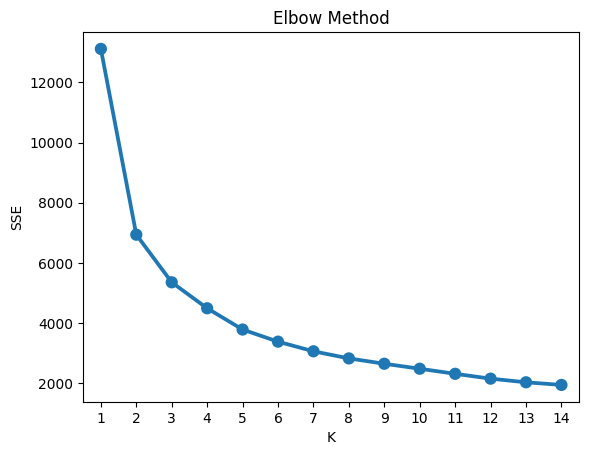

In [ ]:
# Calculate SSE
from sklearn.cluster import KMeans

sse = {}
X = rfm_data_normalized[["Recency", "Frequency", "MonetaryValue"]]
for k in range(1, 15):
  kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
  sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()),
              y=list(sse.values()))
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()

**II. Build 4-cluster solution**

In [ ]:
# Build KMeans Model
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)
cluster_labels = kmeans.labels_

In [ ]:
# Assign cluster to the "normalized data"
rfm_model_k4 = rfm_data_normalized.assign(Cluster=cluster_labels)

# Join the cluster from the normalized data to the original data
new_rfm_data = rfm_data.join(rfm_model_k4["Cluster"])

# Drop Nan values
new_rfm_data.dropna(axis=0, inplace=True)

segment_rfm_k4 = new_rfm_data.groupby(["Cluster"]).agg({
    'Recency':['mean'],
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(1)


segment_rfm_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0.0        12.3     285.0        7429.3   884
1.0       100.0      77.5        1539.9  1335
2.0        17.5      40.2         638.3   817
3.0       182.6      13.9         283.2  1335

<Axes: xlabel='Cluster', ylabel='Recency'>

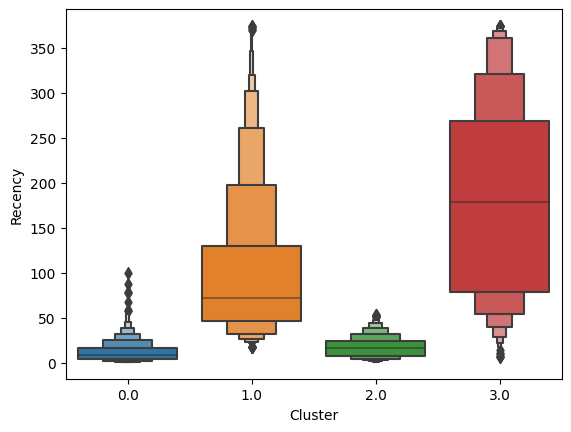

In [ ]:
sns.boxenplot(x=new_rfm_data["Cluster"],
              y=new_rfm_data["Recency"])

<Axes: xlabel='Cluster', ylabel='Frequency'>

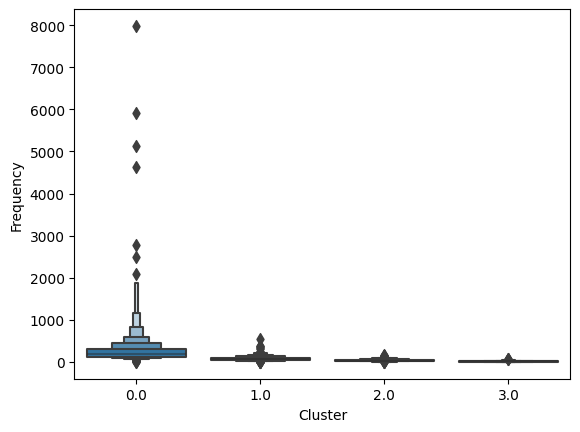

In [ ]:
sns.boxenplot(x=new_rfm_data["Cluster"],
              y=new_rfm_data["Frequency"])

<Axes: xlabel='Cluster', ylabel='MonetaryValue'>

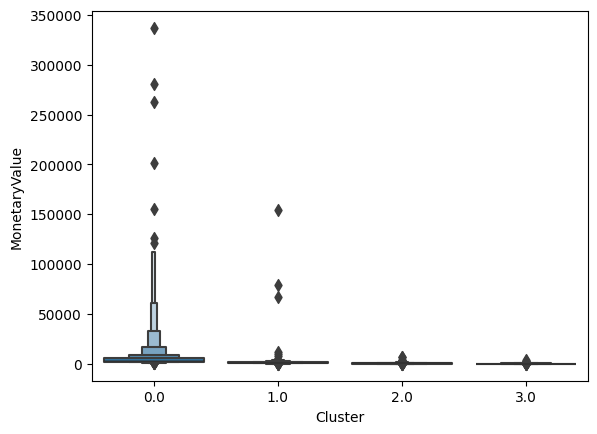

In [ ]:
sns.boxenplot(x=new_rfm_data["Cluster"],
              y=new_rfm_data["MonetaryValue"])

**III. Feature Importance**

In [ ]:
# Calculate average RFM for each cluster
slicer = new_rfm_data[["Recency", "Frequency", "MonetaryValue", "Cluster"]]
cluster_avg = slicer.groupby(["Cluster"]).mean()

# Calculate average RFM for the total customers
population_avg = new_rfm_data[["Recency", "Frequency", "MonetaryValue"]].mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0.0,-0.87,2.06,2.41
1.0,0.09,-0.17,-0.29
2.0,-0.81,-0.57,-0.71
3.0,0.98,-0.85,-0.87


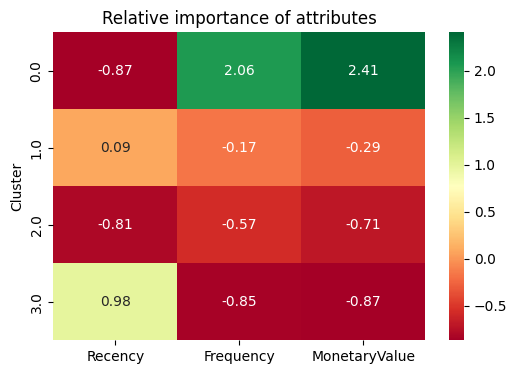

In [ ]:
# Initialize a plot with a figure size of 8 by 2 inches
plt.figure(figsize=(6, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()